<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/completeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için Eksik Tamamlama Yapay Zekası

Bu çalışmada amaç elimizdeki bir kısmı eksik fotoğrafları tamamlayan  bir model eğitmek.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset
import tensorflow as tf
import math
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import clear_output




Burada aslında ImageNet için kullanılmış 256*256 pixel boyutunda resimler bulunan datasetten rastgele alınmış 2010 görselin olduğu bir klasör indiriyoruz. Orijinal datasetin adddres linki -> https://www.kaggle.com/datasets/dimensi0n/imagenet-256

Bunu indirip ya da 256 256 boyutunda olan başka resimler toplayarakta bu projeyyi kullanmak mümkün.

In [2]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archiveExpand.zip"


In [3]:
!unzip -q archiveExpand.zip

In [4]:
# AYARLAR

#Kullandığın kalsör farklı ise ( kendi resim klasörünü yüklediysen) burayı değiştir
image_folder = "archiveExpand"

# Asıl görsellerinin boyutu nedir? Bunları DOWNSCALE_FACTOR kadar küçültüp modeli eğitceğiz,
TARGET_SIZE = (256, 256)  # girişi boyutu 128 px

# batchler 8lik bunu arttırırsan ram kullanımı ve süre artar ama model daha iyi eğitilir.
BATCH_SIZE = 8

# farklı augment işlemleri için sayıyı büyüt
AUGMENT_LEVEL=1

#Renk modu grayscale mi renkli mi
COLOR_MODE_GRAYSCALE=True


BorderMode=False

BORDER_SIZE=15
SQUARE_SIZE=30


#---- Bunlar yukarıya göre otamatik olacak bunları değiştirme ------

start_y = BORDER_SIZE
start_x = BORDER_SIZE
end_y = TARGET_SIZE[1]- BORDER_SIZE
end_x = TARGET_SIZE[0] - BORDER_SIZE



square_start_x=(TARGET_SIZE[0]//2)-(SQUARE_SIZE//2)
square_end_x=(TARGET_SIZE[0]//2)+(SQUARE_SIZE//2)
square_start_y=(TARGET_SIZE[1]//2)-(SQUARE_SIZE//2)
square_end_y=(TARGET_SIZE[1]//2)+(SQUARE_SIZE//2)

# siyah beyaz renk modunda plt.imshow methoduna cmap paramtresi lazım ve model için renk kanalı sayısı belirleniyor

if COLOR_MODE_GRAYSCALE:
  cmapMode="gray"
  channelCount=1

else:
  cmapMode=None
  channelCount=3 #RGB

In [5]:
# Load images and create dataset
border_images, color_images = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    color_img = img_to_array(load_img(img_path, target_size=TARGET_SIZE))
    # Load and resize complete image


    if BorderMode:
      # Burası Resim Çevresine siyah bir çerçeve koyar
      black_border_img = np.zeros_like(color_img)
      black_border_img[start_y:end_y, start_x:end_x] = color_img[start_y:end_y, start_x:end_x]
    else:
      # Burası Resime Siayh bir kare koyar
      black_border_img=color_img.copy()
      black_border_img[square_start_y:square_end_y, square_start_x:square_end_x]=(0, 0, 0)

    if COLOR_MODE_GRAYSCALE:
      # grayscale dönüşümü ile kaybedilen ekseni ekler
      black_border_img = cv2.cvtColor(black_border_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
      black_border_img=np.expand_dims(black_border_img, axis=-1)
      color_img = cv2.cvtColor(color_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
      color_img = np.expand_dims(color_img, axis=-1)
    # Normalize images
    border_images.append(black_border_img / 255.0)
    color_images.append(color_img / 255.0)

    if AUGMENT_LEVEL>=1:
        # Add augmented (flipped) versions to the dataset
        flipped_black_border_img = np.fliplr(black_border_img)
        flipped_color_img = np.fliplr(color_img)
        # Append the flipped images
        border_images.append(flipped_black_border_img / 255.0)
        color_images.append(flipped_color_img / 255.0)
    if AUGMENT_LEVEL>=2:
        # Apply 90° rotation
        rotated_90_border = np.rot90(black_border_img, k=1)  # 90 degrees
        rotated_90_color = np.rot90(color_img, k=1)
        border_images.append(rotated_90_border / 255.0)
        color_images.append(rotated_90_color / 255.0)
    if AUGMENT_LEVEL>=3:
        # Apply 180° rotation
        rotated_180_border = np.rot90(black_border_img, k=2)  # 180 degrees
        rotated_180_color = np.rot90(color_img, k=2)
        border_images.append(rotated_180_border / 255.0)
        color_images.append(rotated_180_color / 255.0)
    if AUGMENT_LEVEL>=4:
        # Apply Gaussian Blur
        blurred_border = cv2.GaussianBlur(black_border_img, (5, 5), 0)  # (5,5) kernel
        blurred_color = cv2.GaussianBlur(color_img, (5, 5), 0)
        border_images.append(blurred_border / 255.0)
        color_images.append(blurred_color / 255.0)


# Convert to NumPy arrays
border_images = np.array(border_images, dtype=np.float32)
color_images = np.array(color_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((border_images, color_images))
dataset = dataset.batch(BATCH_SIZE).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)
print(dataset.element_spec)

# Count total images
total_elements = sum(1 for _ in dataset)
total_images = total_elements * BATCH_SIZE
print(f"Total images in dataset: {total_images}")



(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
Total images in dataset: 4024


In [6]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))


Black White Shape: (4020, 256, 256, 1)
Color Shape: (4020, 256, 256, 1)


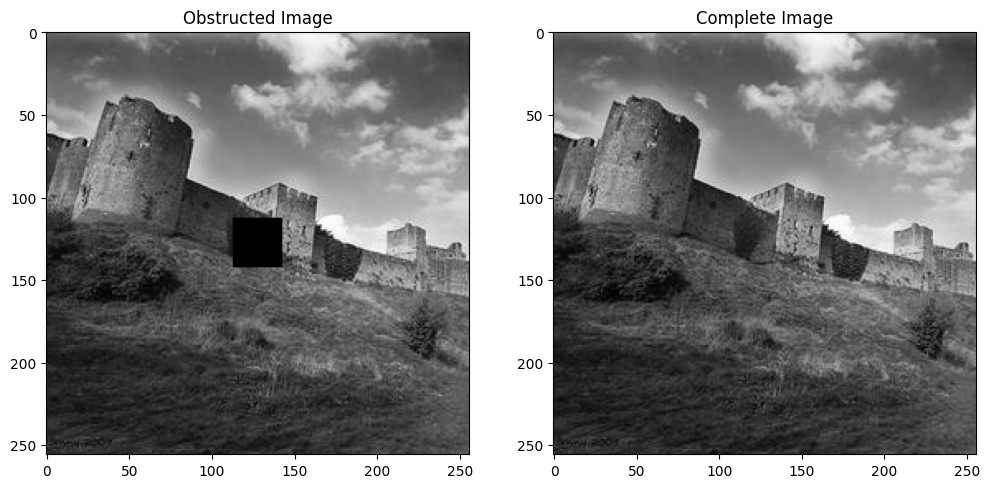

In [7]:

print("Black White Shape:", border_images.shape)
print("Color Shape:", color_images.shape)

# Plot the first image in the batch
plt.figure(figsize=(12, 6))

# Low resolution image
plt.subplot(1, 2, 1)
plt.imshow(border_images[0],cmap=cmapMode)  # Display first image in batch
plt.title("Obstructed Image")

# High resolution image
plt.subplot(1, 2, 2)
plt.imshow(color_images[0],cmap=cmapMode)  # Display first image in batch
plt.title("Complete Image")

plt.show()


In [8]:
# Modeli Oluştur

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Add, Input
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=(3, 3)):
    """Residual block with Conv2D, BatchNorm, and LeakyReLU"""
    res = Conv2D(filters, kernel_size, padding="same")(x)
    res = LeakyReLU(0.2)(res)
    res = BatchNormalization()(res)
    res = Conv2D(filters, kernel_size, padding="same")(res)
    res = BatchNormalization()(res)
    return Add()([x, res])  # Skip connection

def build_flexible_model(x_in, y_in, z_in, x_out, y_out, c_out):
    inputs = Input(shape=(x_in, y_in, z_in))

    # Initial feature extraction
    x = Conv2D(64, (7, 7), padding="same")(inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    # Encoding Path (Downsampling + Residual Blocks)
    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = residual_block(x, 128)

    x = Conv2D(256, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = residual_block(x, 256)

    # Bottleneck
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = residual_block(x, 512)

    # Decoding Path (Upsampling + Residual Blocks)
    x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = residual_block(x, 256)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = residual_block(x, 128)

    # Resize to match output shape
    x = Conv2DTranspose(64, (3, 3), strides=(x_out // x.shape[1], y_out // x.shape[2]), padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    # Final Output Layer
    outputs = Conv2D(c_out, (3, 3), padding="same", activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# Example usage
x_in, y_in, z_in = TARGET_SIZE[0], TARGET_SIZE[1], channelCount   # Input: Grayscale 32x32
x_out, y_out, c_out = TARGET_SIZE[0], TARGET_SIZE[1], channelCount  # Output: RGB 128x128
model = build_flexible_model(x_in, y_in, z_in, x_out, y_out, c_out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 10,787,841 (41.15 MB)

 Trainable params: 10,779,905 (41.12 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [ ]:
#EĞİTİME BAŞLA
EPOCH_COUNT=350

# Parameters to control image display
IMAGE_ROW_COUNT = 3    # Number of images to display
IMAGE_SELECTION_SEED = 14  # Select every nth image
IMAGE_OFFSET = 14       # Start from the x-th image

#resimleri kaydedecek klasörü oluşturduk
save_dir="/content/epochImages/"
os.makedirs(save_dir, exist_ok=True)


class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        val_data_list = list(val_data.unbatch())
        selected_indices = [i for i in range(IMAGE_OFFSET, len(val_data_list), IMAGE_SELECTION_SEED)]
        selected_indices = selected_indices[:IMAGE_ROW_COUNT]
        self.val_data = [val_data_list[i] for i in selected_indices]

        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0
        self.imageCount = 1
    def on_epoch_end(self, epoch, logs=None):

        # early stop
        current_loss = logs.get('loss')

        # Check if the loss has improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If loss hasn't improved for 'patience' epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Create figure with IMAGE_ROW_COUNT rows and 3 columns
        fig, axes = plt.subplots(IMAGE_ROW_COUNT, 3, figsize=(12, 4 * IMAGE_ROW_COUNT))

        for i, (border_images, color_images) in enumerate(self.val_data):
            # Ensure batch dimension
            border_images = tf.expand_dims(border_images, axis=0) if len(border_images.shape) == 3 else border_images
            color_images = tf.expand_dims(color_images, axis=0) if len(color_images.shape) == 3 else color_images

            # Generate prediction
            pred = self.model.predict(border_images)

            # Plot Low-Res Input
            axes[i, 0].imshow(np.clip(border_images[0], 0.0, 1.0),cmap=cmapMode)
            axes[i, 0].set_title(f"Sample {i+1} - Obstructed Image")
            axes[i, 0].axis('off')

            # Plot Model Prediction
            axes[i, 1].imshow(np.clip(pred[0], 0.0, 1.0),cmap=cmapMode)
            axes[i, 1].set_title(f"Sample {i+1} - Prediction")
            axes[i, 1].axis('off')

            # Plot High-Res Ground Truth
            axes[i, 2].imshow(np.clip(color_images[0], 0.0, 1.0),cmap=cmapMode)
            axes[i, 2].set_title(f"Sample {i+1} - Complete Ground Truth")
            axes[i, 2].axis('off')

        plt.tight_layout()
        clear_output(wait=True)

        # Save the figure
        plt.savefig(f'/content/epochImages/epoch_{epoch+1:03d}.png')
        self.imageCount += 1
        plt.show()


# Convert to tf.data.Dataset properly if it's not in batch form yet
val_data = tf.data.Dataset.from_tensor_slices((border_images[:50], color_images[:50]))  # Use 50 samples for validation
val_data = val_data.batch(1)  # Ensure the data is batched

# Add the callback to training
callback = DisplayPrediction(val_data)
#tf.dataset olduğundan batch size yukarda
# Train the model with the callback added history
history = model.fit(dataset, epochs=EPOCH_COUNT, callbacks=[callback])


Epoch 1/350


In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


In [ ]:
from PIL import Image
import os

# Path to the images in the '/content' folder
image_folder = '/content/epochImages/'  # görsellerin olduğğu klasör

# Get a list of all PNG files in the folder and sort them (to maintain correct order)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()  # Sort images to maintain correct order (optional)

# Load all the images into a list
images = []
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path)
    images.append(img)

# Save the images as a GIF
gif_path = '/content/resolution_animation.gif'  # Save the GIF in Colab's content folder
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=400, loop=1) # loop= 0 to endless

print(f"GIF saved to {gif_path}")

In [ ]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


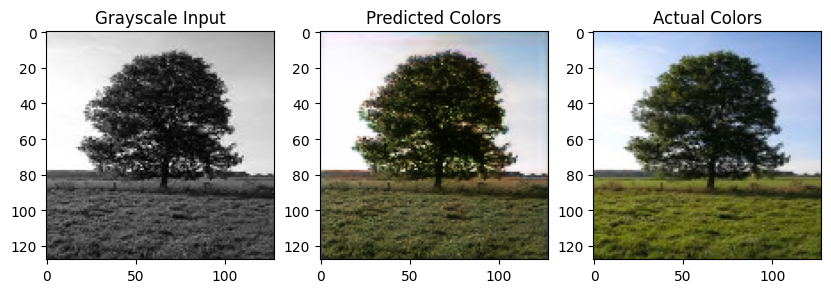

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def color_new_image(model, image_path, target_size=(128, 128)):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # create grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Reshape gray_image to have the correct dimensions
    gray_image = gray_image.reshape(1, target_size[0], target_size[1], 1) #add batch and channel dimension

    # Normalize the images
    gray_image = gray_image / 255.0
    img = img / 255.0

    # Make prediction using the model
    pred = model.predict(gray_image)

    # Return both the resized low-res image and the prediction
    return gray_image[0], pred[0]  # Return gray_image instead of low_res

# Example usage
image_path = "test1.jpg"
low_res, predicted = color_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 3, 1)
plt.imshow(low_res[:,:,0], cmap="gray") #adjusted to display image correctly
plt.title("Grayscale Input")

# Display the predicted high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(predicted)
plt.title("Predicted Colors")

plt.subplot(1, 3, 3)
img=cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(128,128))
plt.imshow(img) #adjusted to display image correctly
plt.title("Actual Colors")



plt.show()

Sace and use later

In [ ]:
# Save the model in H5 format
model.save("color_model.keras")


In [ ]:
loaded_model = tf.keras.models.load_model("color_model.keras")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path):
    # Load the new image and resize it to 128,128
    img = img_to_array(load_img(image_path, target_size=(128,128)))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"

# Load model (if already saved and needs to be loaded)
# model = tf.keras.models.load_model("upscaler_model.h5")

# Predict with the model
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()

# Save model for later use
model.save("upscaler_model.h5")  # Save the model

ValueError: as_list() is not defined on an unknown TensorShape.

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
from google.colab import files

# Path to the images in the '/content' folder
image_folder = '/content/epochImages/'  # Görsellerin olduğu klasör

# Get a list of all PNG files in the folder and sort them (to maintain correct order)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()  # Sort images to maintain correct order (optional)

# Parameters for the video
frame_width, frame_height = None, None
video_path = '/content/resolution_animation.avi'  # Path to save the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI format

# Set the desired frames per second (change this value to suit your needs)
fps = 10  # Example: Set to 30 frames per second

# Initialize the VideoWriter object
video_writer = None
frames = []  # List to hold frames before writing them

# Process and add frames to the video
for i, image_file in enumerate(image_files):
    if i % 1 == 0:  # Take every 2nd frame
        image_path = os.path.join(image_folder, image_file)
        img = Image.open(image_path)

        # Crop to the lowest third of the image
        width, height = img.size
        lower_third = (0, height * 2 // 3, width, height)  # Coordinates for the lower third
        cropped_img = img.crop(lower_third)

        # Convert the cropped image to a format OpenCV can use
        frame = cv2.cvtColor(np.array(cropped_img), cv2.COLOR_RGB2BGR)

        # Add the frame to the list
        frames.append(frame)

# Add the last frame 15 more times
if frames:
    last_frame = frames[-2]  # Get the last frame
    for _ in range(25):  # Repeat the last frame 15 times
        frames.append(last_frame)

# Set video dimensions and write frames to the video
if frames:
    frame_height, frame_width = frames[0].shape[:2]
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))

    # Write all frames to the video
    for frame in frames:
        video_writer.write(frame)

# Release the video writer object and finalize the video
video_writer.release()

print(f"Video saved to {video_path}")

# For downloading the video in Colab
files.download(video_path)